## Aprendizaje Automático Supervisado

## 3º GrIA, USC

# Práctica 1: Árboles de Decisión y Selección de Modelos

Este fichero Notebook contiene la solución del siguiente equipo al guion de prácticas proporcionado en el Aula Virtual de la asignatura.

Miembros del equipo:
- _Estudiante1_: Mateo, Fraguas Abal
- _Estudiante2_: Álvaro, Garnelo Luaces
- _Estudiante3_: Karol, Badura

# 1. Instalación de Paquetes

Escribe en la siguiente celda de código las instrucciones necesarias para cargar los paquetes de Python que necesitéis

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Además, para garantizar la reproducibilidad de resultados vamos a fijar una semilla que se use con todos los algoritmos que tengan alguna componente no determinista (**no cambies el código de la siguiente celda**).

In [21]:
# Definir semilla
SEMILLA = 1492
np.random.seed(SEMILLA)

# 2. Carga de Datos

Escribe en la siguiente celda de código las instrucciones necesarias para cargar los conjuntos de datos (ficheros csv) proporcionados en el Aula Virtual. Para el pre-procesado y análisis de los datos podéis añadir las celdas que necesitéis.

Descarga y Preprocesamiento de los Datos

1. Importar los datos  
2. Eliminar duplicados  
3. Eliminar columnas irrelevantes (por ejemplo, “id” en *df1*) y aquellas con 500 o más valores faltantes  
4. Dividir en X (características) y y (variable objetivo)  
5. Manejar los datos faltantes (imputación por media, mediana o KNN)  
6. Codificar las variables categóricas como numéricas  
7. Normalizar los datos al rango [0, 1]

#### Importar los datos

In [22]:
df1 = pd.read_csv("data/breast-cancer-train.csv")
df2 = pd.read_csv("data/adult-train.csv")

In [23]:
# df1
# df2

# EDA - TODO

#### Eliminación de duplicados

In [24]:
# Cuantos datos duplicados
print("cancer: ", df1.duplicated().sum())
print("adults: ", df2.duplicated().sum())

cancer:  4
adults:  24


In [25]:
# Eliminacion de duplicados
df1_clean = df1.drop_duplicates() 
df2_clean = df2.drop_duplicates()

In [26]:
# Verificar si la eliminación funcionó
print("cancer: ", df1_clean.duplicated().sum())
print("adults: ", df2_clean.duplicated().sum())

cancer:  0
adults:  0


#### Eliminar columnas irrelevantes

In [27]:
# La columna ID es irrelevante para la predicción, por lo tanto la eliminamos
df1_clean = df1_clean.drop(columns=['id'])

# Calcular los valores faltantes para cada conjunto de datos
missing_X1 = df1_clean.isna().sum()
missing_X2 = df2_clean.isna().sum()

# Mostrar las columnas con 500 o más valores faltantes (si las hay)
print("Columnas en df1 (BreastCancer) con >= 500 valores faltantes:")
for col, val in missing_X1[missing_X1 >= 500].items():
    print(f"  {col}: {val}")

print("\nColumnas en df2 (Adult) con >= 500 valores faltantes:")
for col, val in missing_X2[missing_X2 >= 500].items():
    print(f"  {col}: {val}")

Columnas en df1 (BreastCancer) con >= 500 valores faltantes:

Columnas en df2 (Adult) con >= 500 valores faltantes:
  workclass: 1836
  occupation: 1843
  nativeCountry: 582


In [28]:
# Eliminación de columnas con demasiados valores faltantes (≥ 500)
cols_to_drop = ['workclass', 'occupation', 'nativeCountry']

# Eliminar solo si esas columnas existen en el DataFrame
df2_clean = df2_clean.drop(columns=[col for col in cols_to_drop if col in df2_clean.columns], errors='ignore')

# Verificar los valores faltantes restantes
print(f"Total de valores faltantes después de la eliminación de columnas: {df2_clean.isna().sum().sum()}")

Total de valores faltantes después de la eliminación de columnas: 0


#### División en X e y y codificación de la variable objetivo

In [29]:
# Breast Cancer
X1 = df1_clean.drop(columns=['diagnosis']) 
y1 = df1_clean['diagnosis'].map({'M': 0, 'B': 1})

# Adult
X2 = df2_clean.drop(columns=['outputClass']) 
y2 = df2_clean['outputClass'].map({'<=50K': 1, '>50K': 0})

pd.isna(X2).sum()

age              0
fnlwgt           0
education        0
educationNum     0
maritalStatus    0
relationship     0
race             0
sex              0
capitalGain      0
capitalLoss      0
hoursPerWeek     0
dtype: int64

#### Gestión de datos faltantes

In [30]:
# IMPUTACION USANDO LA MEDIA
imputer_mean = SimpleImputer(strategy='mean')
X1_mean = pd.DataFrame(imputer_mean.fit_transform(X1), columns=X1.columns)

# IMPUTACION USANDO LA MEDIANA
imputer_median = SimpleImputer(strategy='median')
X1_median = pd.DataFrame(imputer_median.fit_transform(X1), columns=X1.columns)

# IMPUTACION MEDIANTE LOS KVECINOS
knn_imputer = KNNImputer(n_neighbors=5)
X1_knn = pd.DataFrame(knn_imputer.fit_transform(X1), columns=X1.columns)

#### Codificación de variables categóricas 

In [31]:
# Identificar columnas categóricas y numéricas
categoricas = X2.select_dtypes(include=['object']).columns
numericas = X2.select_dtypes(include=np.number).columns

# Aplicamos One-Hot Encoding a las variables categóricas. Esto crea una nueva
# columna binaria para cada categoría posible.
X2_encoded = pd.get_dummies(X2, columns=categoricas, drop_first=True)

print("\nPrimeras 5 filas de datos de Adult tras One-Hot Encoding:")
print(X2_encoded.head())


Primeras 5 filas de datos de Adult tras One-Hot Encoding:
   age  fnlwgt  educationNum  capitalGain  capitalLoss  hoursPerWeek  \
0   39   77516            13         2174            0            40   
1   50   83311            13            0            0            13   
2   38  215646             9            0            0            40   
3   53  234721             7            0            0            40   
4   28  338409            13            0            0            40   

   education_11th  education_12th  education_1st-4th  education_5th-6th  ...  \
0           False           False              False              False  ...   
1           False           False              False              False  ...   
2           False           False              False              False  ...   
3            True           False              False              False  ...   
4           False           False              False              False  ...   

   relationship_Not-in-fami

#### Normalización de los datos

In [32]:
# Normalizacion
scaler = MinMaxScaler()

X1_norm_mean = pd.DataFrame(scaler.fit_transform(X1_mean), columns=X1_mean.columns)
X1_norm_median = pd.DataFrame(scaler.fit_transform(X1_median), columns=X1_median.columns)
X1_norm_knn = pd.DataFrame(scaler.fit_transform(X1_knn), columns=X1_knn.columns)

X2_norm = pd.DataFrame(scaler.fit_transform(X2_encoded), columns=X2_encoded.columns)

# 3. Creación y Validación de Modelos

Escribe en la siguiente celda de código las instrucciones necesarias para crear, validar y seleccionar los modelos aprendidos a partir de los datos tratados en la sección anterior. Podéis añadir las celdas que necesitéis.

What will we do

1. Split the data into training and test sets  
2. Define the cross-validation strategy  
3. Create two models: **KNN** and **Decision Tree**  
4. Compare the results and pick the best model  
5. Train the best model on the full dataset  
6. Compare overall perfore7rics  
8. Di scuss th findings
results**

#### Split

In [33]:
# Divide el conjunto de datos en una proporción estándar de 80/20 (entrenamiento/prueba)
# Utiliza un muestreo estratificado para mantener el equilibrio entre las clases (M y B)

X1_train_mean, X1_test_mean, y1_train_mean, y1_test_mean = train_test_split(
    X1_norm_mean, y1, test_size=0.2, stratify=y1, random_state=SEMILLA
)

X1_train_median, X1_test_median, y1_train_median, y1_test_median = train_test_split(
    X1_norm_median, y1, test_size=0.2, stratify=y1, random_state=SEMILLA
)

X1_train_KNN, X1_test_KNN, y1_train_KNN, y1_test_KNN = train_test_split(
    X1_norm_knn, y1, test_size=0.2, stratify=y1, random_state=SEMILLA
)

#### Define variables

In [34]:
# Se emplea validación cruzada estratificada para preservar la proporción de clases en cada fold.
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEMILLA)

param_grid_knn = {
    'n_neighbors': list(range(1, 20, 2)),
    'weights' : ['uniform','distance']
}

param_grid_dt = {
    'max_depth': list(range(1, 11)),
    'min_samples_split': list(range(2, 11))
}

resultados_globales = []

#### Run KNN-model for each imputation

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def KNN_modelo(X_train, y_train, X_test, y_test, tipo, param_grid_knn):
    knn = KNeighborsClassifier()
    grid_knn = GridSearchCV(knn, param_grid_knn,
                        cv=cv, scoring='accuracy', n_jobs=-1, return_train_score=True)
    # Entrenamiento
    grid_knn.fit(X_train, y_train)

    # 
    results_df = pd.DataFrame(grid_knn.cv_results_)
    mejor_resultado = grid_knn.best_score_
    desviacion = results_df.loc[grid_knn.best_index_, 'std_test_score']
    threshold = mejor_resultado - desviacion

    # Aplicación de la Regla 1-std
    candidatos = results_df[results_df['mean_test_score'] >= threshold]
    candidatos_ordenados = candidatos.sort_values(by=['param_n_neighbors', 'param_weights'])
    simple_knn_model = candidatos_ordenados.iloc[0]

    # Mostrar resultados
    print(f"Imputer: {tipo}")
    print(f"Mejor modelo: k={grid_knn.best_params_['n_neighbors']}, weights='{grid_knn.best_params_['weights']}'")
    print(f"Accuracy (CV): {mejor_resultado:.4f} ± {desviacion:.4f}")
    print(f"Regla 1-std → k={int(simple_knn_model['param_n_neighbors'])}, weights='{simple_knn_model['param_weights']}', "
          f"Accuracy={simple_knn_model['mean_test_score']:.4f}")

    # Evaluación en el conjunto de prueba
    y_pred = grid_knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy de test: {accuracy:.4f}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    # Guardar resultados globales
    resultados_globales.append({
        'Modelo': f'KNN ({tipo})',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

    # Visualización de errores de validación
    for w in param_grid_knn['weights']:
        errores = [
            1 - grid_knn.cv_results_['mean_test_score'][i]
            for i, params in enumerate(grid_knn.cv_results_['params'])
            if params['weights'] == w
        ]
        plt.plot(param_grid_knn['n_neighbors'], errores, marker='o', label=f"Weights: {w}")

    plt.axhline(1 - threshold, color='red', linestyle='--', label='Threshold (1-std)')
    plt.xlabel("Número de vecinos (k)")
    plt.ylabel("Error de validación cruzada")
    plt.title(f"KNN ({tipo}) - Validación Cruzada")
    plt.legend()
    plt.grid(True)
    plt.show()

Imputer: mean
Mejor modelo: k=3, weights='uniform'
Accuracy (CV): 0.9851 ± 0.0149
Regla 1-std → k=3, weights='distance', Accuracy=0.9851
Accuracy de test: 0.9405
Precision: 0.9333 | Recall: 0.9825 | F1: 0.9573


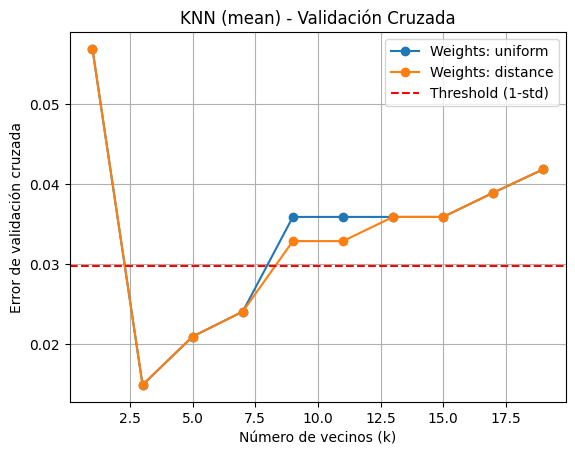

Imputer: median
Mejor modelo: k=3, weights='uniform'
Accuracy (CV): 0.9851 ± 0.0149
Regla 1-std → k=3, weights='distance', Accuracy=0.9851
Accuracy de test: 0.9405
Precision: 0.9333 | Recall: 0.9825 | F1: 0.9573


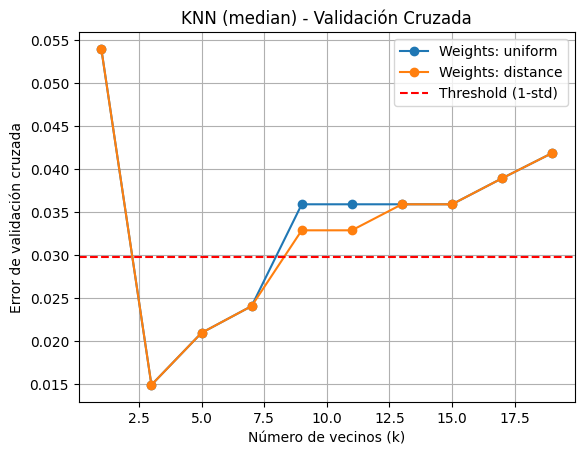

Imputer: knn
Mejor modelo: k=3, weights='uniform'
Accuracy (CV): 0.9821 ± 0.0146
Regla 1-std → k=3, weights='distance', Accuracy=0.9821
Accuracy de test: 0.9405
Precision: 0.9333 | Recall: 0.9825 | F1: 0.9573


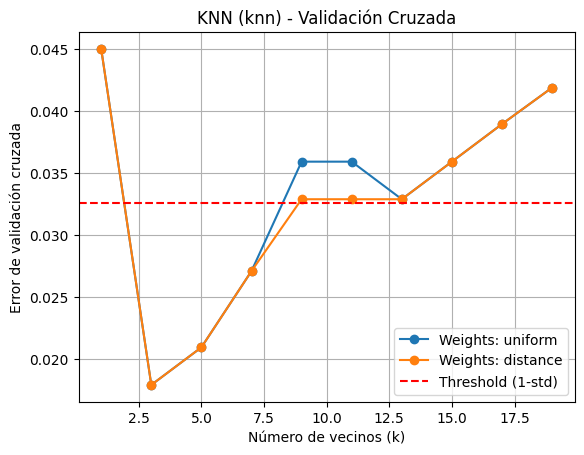

In [38]:
KNN_modelo(X1_train_mean, y1_train_mean, X1_test_mean, y1_test_mean, 'mean', param_grid_knn)
KNN_modelo(X1_train_median, y1_train_median, X1_test_median, y1_test_median, 'median', param_grid_knn)
KNN_modelo(X1_train_KNN, y1_train_KNN, X1_test_KNN, y1_test_KNN, 'knn', param_grid_knn)

#### Run DT-model for each imputation

In [39]:
def DT_modelo(X_train, y_train, X_test, y_test, tipo):
    # Definir modelo base y los hiperparámetros a ajustar
    dt = DecisionTreeClassifier(criterion='entropy', random_state=SEMILLA)

    grid_dt = GridSearchCV(dt, param_grid_dt,
                       cv=cv, scoring='accuracy', n_jobs=-1, return_train_score=True)
    grid_dt.fit(X_train, y_train)

    # Resultados del GridSearch
    resultados_dt = pd.DataFrame(grid_dt.cv_results_)
    scores = np.array(resultados_dt['mean_test_score']).reshape(
        len(param_grid_dt['max_depth']),
        len(param_grid_dt['min_samples_split'])
    )

    # Heatmap de resultados
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        scores, annot=True, cmap='viridis',
        xticklabels=param_grid_dt['min_samples_split'],
        yticklabels=param_grid_dt['max_depth']
    )
    plt.xlabel('min_samples_split')
    plt.ylabel('max_depth')
    plt.title(f'Heatmap de Accuracy para Árbol de Decisión ({tipo})')

    # Añadir visualización del threshold (línea horizontal)
    best_score_dt = grid_dt.best_score_
    std_dev_dt = resultados_dt.loc[grid_dt.best_index_, 'std_test_score']
    threshold_dt = best_score_dt - std_dev_dt

    # Encuentra la(s) fila(s) donde el accuracy supera el threshold
    for i, max_depth in enumerate(param_grid_dt['max_depth']):
        for j, min_samples_split in enumerate(param_grid_dt['min_samples_split']):
            if scores[i, j] >= threshold_dt:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))

    plt.show()

    # Aplicación de la regla de 1 desviación estándar
    simple_dt_candidates = resultados_dt[resultados_dt['mean_test_score'] >= threshold_dt]
    simple_dt_model = simple_dt_candidates.sort_values(by=['param_max_depth', 'param_min_samples_split']).iloc[0]

    # Mostrar resultados
    print(f"Imputer: {tipo}")
    print(f" Mejor modelo: max_depth={grid_dt.best_params_['max_depth']}, "
          f"min_samples_split={grid_dt.best_params_['min_samples_split']}, "
          f"Accuracy (CV)={best_score_dt:.4f}, Std={std_dev_dt:.4f}")
    print(f"Regla 1-std → max_depth={int(simple_dt_model['param_max_depth'])}, "
          f"min_samples_split={int(simple_dt_model['param_min_samples_split'])}, "
          f"Accuracy={simple_dt_model['mean_test_score']:.4f}")

    # Evaluar en X_test
    y_pred = grid_dt.predict(X_test)
    print(f" Accuracy de test: {accuracy_score(y_test, y_pred):.4f}")

    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

    # Métricas adicionales
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    resultados_globales.append({
        'Modelo': f'DT ({tipo})',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

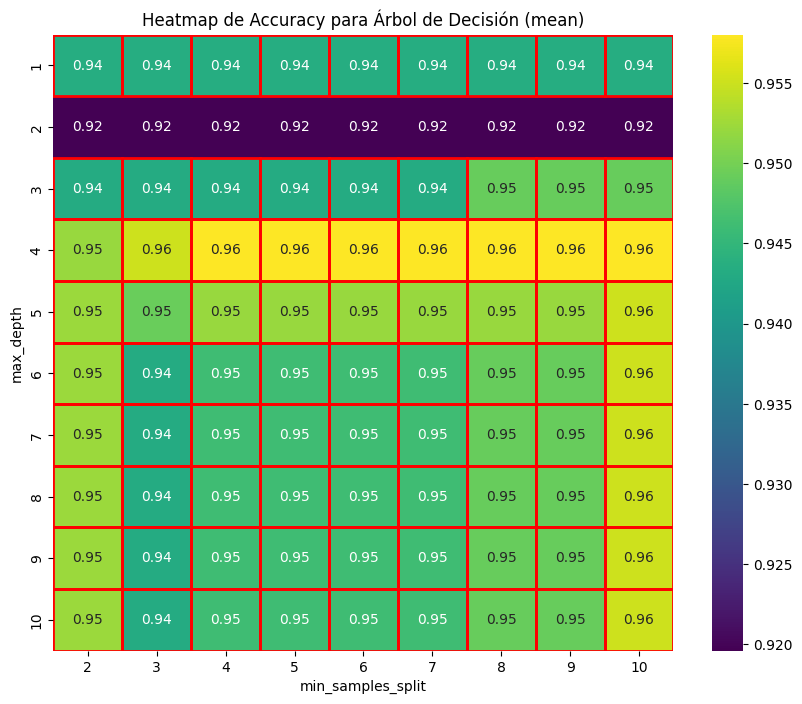

Imputer: mean
 Mejor modelo: max_depth=4, min_samples_split=4, Accuracy (CV)=0.9580, Std=0.0333
Regla 1-std → max_depth=1, min_samples_split=2, Accuracy=0.9434
 Accuracy de test: 0.8929


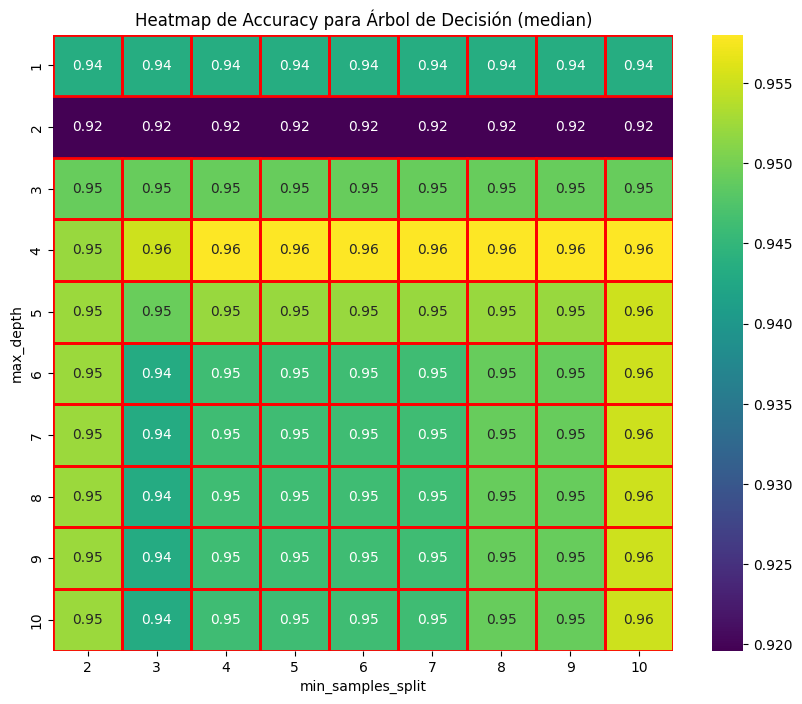

Imputer: median
 Mejor modelo: max_depth=4, min_samples_split=4, Accuracy (CV)=0.9580, Std=0.0333
Regla 1-std → max_depth=1, min_samples_split=2, Accuracy=0.9434
 Accuracy de test: 0.8929


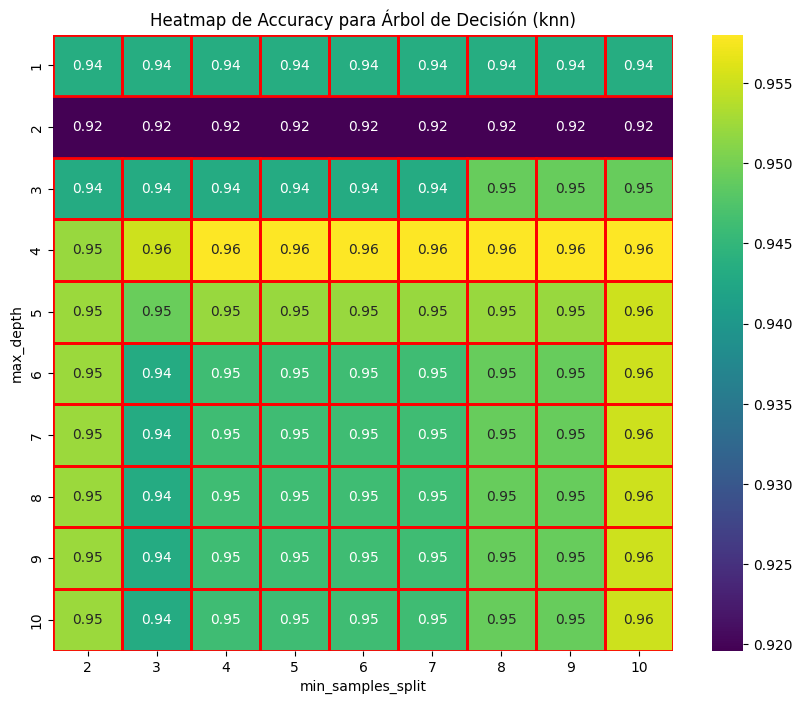

Imputer: knn
 Mejor modelo: max_depth=4, min_samples_split=4, Accuracy (CV)=0.9580, Std=0.0333
Regla 1-std → max_depth=1, min_samples_split=2, Accuracy=0.9434
 Accuracy de test: 0.8929


In [40]:
DT_modelo(X1_train_mean, y1_train_mean, X1_test_mean, y1_test_mean, 'mean')
DT_modelo(X1_train_median, y1_train_median, X1_test_median, y1_test_median, 'median')
DT_modelo(X1_train_KNN, y1_train_KNN, X1_test_KNN, y1_test_KNN, 'knn')

#### Compare results and pick best models

In [41]:
resultados_df = pd.DataFrame(resultados_globales)
display(resultados_df.sort_values(by="Accuracy", ascending=False))

,Modelo,Accuracy,Precision,Recall,F1
0,KNN (mean),0.940476,0.933333,0.982456,0.957265
1,KNN (mean),0.940476,0.933333,0.982456,0.957265
2,KNN (median),0.940476,0.933333,0.982456,0.957265
3,KNN (knn),0.940476,0.933333,0.982456,0.957265
4,DT (mean),0.892857,0.900000,0.947368,0.923077
5,DT (median),0.892857,0.900000,0.947368,0.923077
6,DT (knn),0.892857,0.900000,0.947368,0.923077


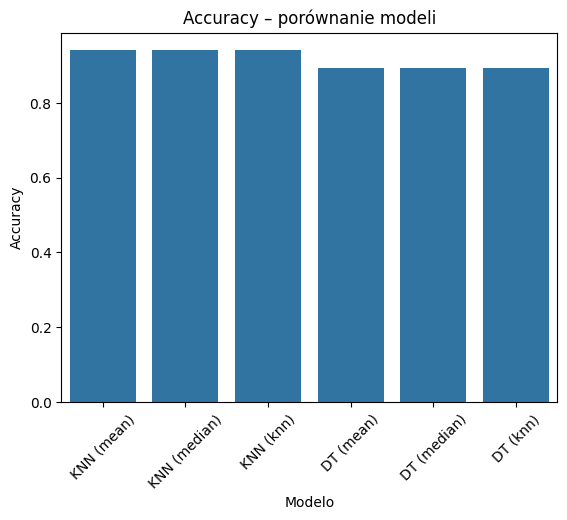

In [42]:
sns.barplot(x='Modelo', y='Accuracy', data=resultados_df)
plt.xticks(rotation=45); plt.title("Accuracy – porównanie modeli"); plt.show()

#### Train the best model on the full dataset

In [43]:
# Para el dataset Breast Cancer
final_params_cancer = {
    'n_neighbors': 3,
    'weights': 'uniform'
}
final_model_cancer = KNeighborsClassifier(**final_params_cancer)
final_model_cancer.fit(X1_norm_mean, y1)
print("Modelo final para Breast Cancer entrenado correctamente.")

# Para el dataset Adult
final_params_adult = {
    'criterion': 'entropy',
    'max_depth': 6,
    'min_samples_split': 2,
    'random_state': SEMILLA
}
final_model_adult = DecisionTreeClassifier(**final_params_adult)
final_model_adult.fit(X2_norm, y2)
print("Modelo final para Adult entrenado correctamente.")

Modelo final para Breast Cancer entrenado correctamente.
Modelo final para Adult entrenado correctamente.


#### Comparison of performance

In [44]:
y_pred_cancer = final_model_cancer.predict(X1_norm_mean)
y_pred_adult = final_model_adult.predict(X2_norm)

print(f"Accuracy (Breast Cancer): {accuracy_score(y1, y_pred_cancer):.4f}")
print(f"Accuracy (Adult): {accuracy_score(y2, y_pred_adult):.4f}")

Accuracy (Breast Cancer): 0.9833
Accuracy (Adult): 0.8540


In [45]:
comparacion_final = pd.DataFrame({
    'Dataset': ['Breast Cancer', 'Adult'],
    'Modelo': ['KNN', 'Decision Tree'],
    'Accuracy final': [
        accuracy_score(y1, y_pred_cancer),
        accuracy_score(y2, y_pred_adult)
    ]
})
display(comparacion_final)

,Dataset,Modelo,Accuracy final
0,Breast Cancer,KNN,0.983294
1,Adult,Decision Tree,0.853982


#### Discussion

In [ ]:
# STUFF FROM THE GOOGLE_DOC AND PREVIOUS CODE